# `CLOUD.jl` - 1D linear advection with dynamic mode decomposition

In [1]:
using CLOUD
using OrdinaryDiffEq
using LinearAlgebra
using TimerOutputs
results_path = "../results/advection_dgmulti_1D_linear_test/";

Define the physical problem

In [2]:
a = 1.0  # advection velocity
A = 1.0  # amplitude
L = 1.0  # domain length
k = 2*π/L  # wave number
T = 1*L/a  # end time
initial_data = InitialDataSine(A,k)
conservation_law = linear_advection_equation(a,λ=1.0);

Set up a quadrature-based DG scheme of degree `p` with `M` elements and periodic boundary conditions

In [3]:
M = 4  # number of elements
p = 3  # degree of discretization

reference_approximation = ReferenceApproximation(
    DGMulti(p), Line(), N_plot=20)
spatial_discretization = SpatialDiscretization(uniform_periodic_mesh(
    reference_approximation.reference_element, 
    (0.0,L), M), reference_approximation)
form = WeakConservationForm()
strategy = Lazy()
solver = Solver(conservation_law, spatial_discretization, form, strategy)

results_path = save_project(conservation_law,
     spatial_discretization, initial_data, form, 
     (0.0, T), strategy, results_path, overwrite=true, clear=true);

Set post-processing and plotting options

In [4]:
error_analysis = ErrorAnalysis(results_path, conservation_law, 
    spatial_discretization)
conservation_analysis = PrimaryConservationAnalysis(results_path, 
    conservation_law, spatial_discretization)
energy_analysis = EnergyConservationAnalysis(results_path, 
    conservation_law, spatial_discretization)

tol = 1.0e-12
n_s = prod(get_dof(spatial_discretization,conservation_law))
r = n_s-2
linear_analysis = LinearAnalysis(results_path, conservation_law, spatial_discretization,
    LinearResidual(solver), r=r, tol=tol)
dmd_analysis = DMDAnalysis(results_path, conservation_law, 
    spatial_discretization, r=r, tol=tol)
plotter = Plotter(spatial_discretization, string(results_path,"plots/"));

Run the `OrdinaryDiffEq` solver, taking `n_s` snapshots

In [5]:
dt_scale=0.1
dt = dt_scale*(L/M)/(a*(2*p+1))
n_t = floor(Int, T/dt)
u0 = initialize(initial_data, conservation_law, spatial_discretization)
ode_problem = semidiscretize(solver, u0, (0.0, T))
save_solution(u0, 0.0, results_path, 0)
sol = solve(ode_problem, Tsit5(), adaptive=false, 
    dt=T/n_t, save_everystep=false,
    callback=save_callback(results_path, floor(Int, n_t/(n_s-1))))
save_solution(last(sol.u), last(sol.t), results_path, "final");

Visualize the solution

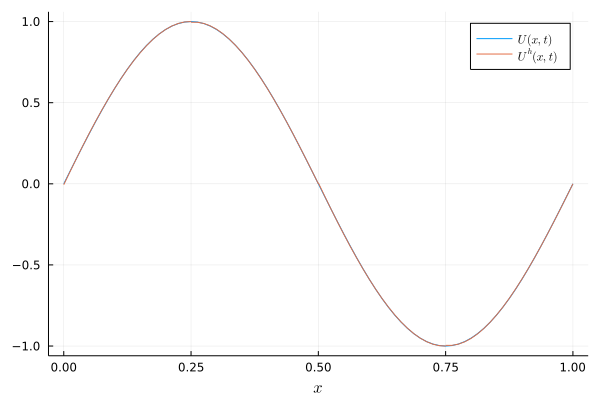

In [6]:
visualize(last(sol.u), plotter, "solution.pdf", exact_solution=initial_data,
    label="U^h(x,t)", label_exact="U(x,t)")

Run analyses

In [7]:
println("L2 error:\n", analyze(error_analysis, last(sol.u), initial_data))
println("Conservation (initial/final/diff):\n", analyze(conservation_analysis)...)
println("Energy (initial/final/diff):\n",analyze(energy_analysis)...)
linear_results = analyze(linear_analysis)
dmd_results = analyze(dmd_analysis);

L2 error:
[0.0009692193775059875]


Conservation (initial/final/diff):


[-1.942890293094024e-16][-2.7755575615628914e-16][-8.326672684688674e-17]


Energy (initial/final/diff):
[0.5000000000000004][0.4999076605837545][-9.233941624592346e-5]


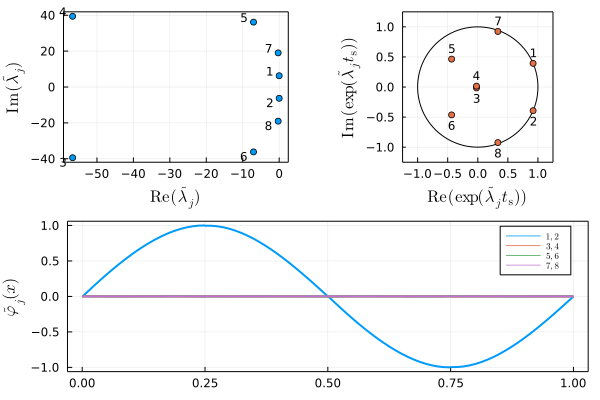

In [8]:
plot_analysis(linear_analysis, linear_results)

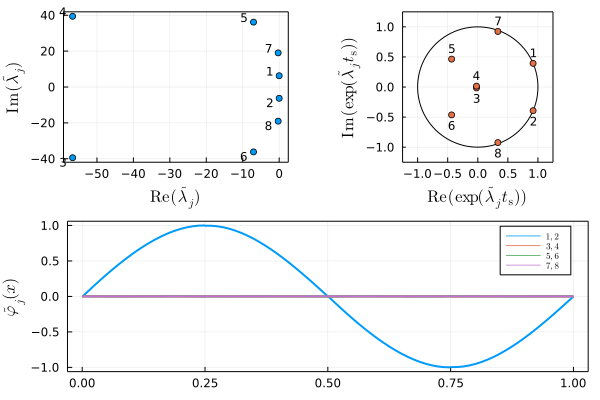

In [9]:
plot_analysis(dmd_analysis, dmd_results)